###**Variational Autoencoder <br>**

(Riya Arora)


---


In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

In [2]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda





---


##### **Part A: Implement basic VAE on celebA faces dataset.**

In [6]:
import kagglehub

path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

100%|██████████| 1.33G/1.33G [01:02<00:00, 23.0MB/s]

Extracting files...


In [9]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [11]:
!ls -R /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2 | head -n 30

/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2:
img_align_celeba
list_attr_celeba.csv
list_bbox_celeba.csv
list_eval_partition.csv
list_landmarks_align_celeba.csv

/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba:
img_align_celeba

/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba:
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg


In [5]:
# !unzip '/content/drive/MyDrive/img_align_celeba.zip' -d '/content/sample_data/b21118-data-new/'

unzip:  cannot find or open /content/drive/MyDrive/img_align_celeba.zip, /content/drive/MyDrive/img_align_celeba.zip.zip or /content/drive/MyDrive/img_align_celeba.zip.ZIP.


In [4]:
# !ls '/content/sample_data/b21118-data-new/img_align_celeba'

ls: cannot access '/content/sample_data/b21118-data-new/img_align_celeba': No such file or directory


In [12]:
output_dir = "/content/sample_data/b21118-results"
os.makedirs(output_dir, exist_ok=True)

In [13]:
# Data Hyperparameters
batch_size = 128
image_size = 64

In [14]:
# Data
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

data_dir = "/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
# Model Params
epochs = 20
latent_dim = 64
learning_rate = 1e-3

In [16]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # [64, 32, 32]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # [128, 16, 16]
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # [256, 8, 8]
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),  # [512, 4, 4]
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.model(x).view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

In [17]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.fc(z).view(z.size(0), 512, 4, 4)
        return self.model(x)

In [18]:
# VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
epochs = 10

# Training
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataset):.4f}")

    # Sae sample images and checkpoints at every epoch
    model.eval()
    with torch.no_grad():
      sample = torch.randn(16, latent_dim).to(device)
      generated_images = model.decoder(sample)
      save_image(generated_images, os.path.join(output_dir, f"epoch_{epoch + 1}.png"), nrow=4)
      torch.save({'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()}, "/content/sample_data/b21118-results/checkpoint.pth")

print("Training completed. Sample images saved to", output_dir)

Epoch 1/10, Loss: 706.3944
Epoch 2/10, Loss: 501.7293
Epoch 3/10, Loss: 481.8282
Epoch 4/10, Loss: 472.7718
Epoch 5/10, Loss: 467.1356
Epoch 6/10, Loss: 463.0683
Epoch 7/10, Loss: 459.5161
Epoch 8/10, Loss: 457.1321
Epoch 9/10, Loss: 454.6998
Epoch 10/10, Loss: 452.9293
Training completed. Sample images saved to /content/sample_data/b21118-results


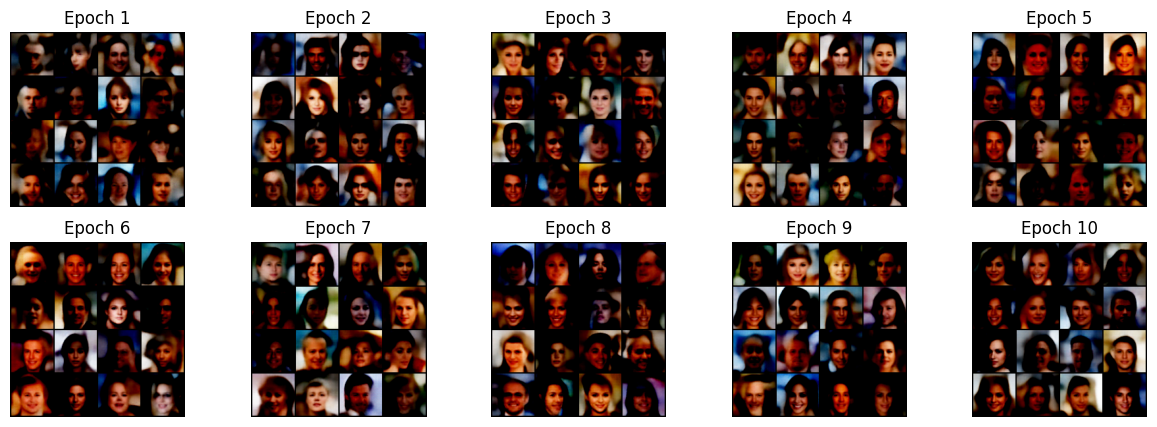

In [22]:
# Epoch-wise Results
from PIL import Image

epoch_images = [f"epoch_{i+1}.png" for i in range(epochs)]

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, epoch_image in enumerate(epoch_images):
    image_path = os.path.join(output_dir, epoch_image)
    img = Image.open(image_path)

    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Epoch {i+1}")

plt.show()



---


##### **Part B: Latent Space arithmetic- Make your image smile.**

##### Modifying images in the original space first.

In [ ]:
# Computing average faces with and without smiling